In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cell 1: ติดตั้ง dependencies
!pip install unsloth[colab-new] transformers datasets torch accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.2/376.2 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.8/162.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8

In [3]:
!pip install --upgrade transformers

In [4]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=85b7639da158e48a82e90384a9146dff6632c8e681ceb900ea8264fccaec9402
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [5]:
# ดาวน์โหลดฟอนต์ Noto Sans Thai
!wget -q https://github.com/google/fonts/raw/main/ofl/notosansthai/NotoSansThai-Regular.ttf \
       -P /usr/share/fonts/truetype/noto/

# รีเฟรช cache ของฟอนต์
!fc-cache -f -v

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [25]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans Thai'
plt.rcParams['axes.unicode_minus'] = False
print("Thai font ready!")

# ─── Cell 1: Setup & Dependencies ─────────────────────────────
import os, gc, json, random, re, torch
from collections import defaultdict
from datasets import Dataset
from transformers import AutoTokenizer, TrainingArguments, EarlyStoppingCallback
from unsloth import FastLanguageModel
from trl import SFTTrainer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.cuda.empty_cache(); gc.collect()

MODEL_NAME      = "unsloth/Llama-3.2-1B-bnb-4bit"
DATA_PATH       = "/content/drive/MyDrive/nsc/data/36strategies-map-game-moves.json"
OUTPUT_DIR      = "/content/drive/MyDrive/nsc/model"
EPOCHS, BATCH_SIZE, LR = 3, 2, 2e-4
MAX_SEQ_LENGTH  = 512

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Setup done. GPU:", torch.cuda.is_available())

Thai font ready!


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Setup done. GPU: True


In [26]:
# ─── Cell 2: Data Augmentation & Prompt Formatting ────────────
def augment_data(raw, min_per_strategy=30):
    groups = defaultdict(list)
    for item in raw:
        strat = item['output'].split('\n')[0].replace('กลยุทธ์: ','').strip()
        groups[strat].append(item)
    aug, counts = [], defaultdict(int)
    variations = [
        "จากการเดินหมากนี้ แสดงถึงการใช้กลยุทธ์ใด",
        "หมากที่เดินนี้ใช้กลยุทธ์อะไร",
        "วิเคราะห์กลยุทธ์จากการเดินหมาก",
        "การเดินหมากนี้เป็นการประยุกต์ใช้กลยุทธ์ใด"
    ]
    for strat, items in groups.items():
        aug.extend(items)
        while len(items) + counts[strat] < min_per_strategy:
            src = random.choice(items)
            aug.append({
                "instruction": random.choice(variations),
                "input": src["input"],
                "output": src["output"]
            })
            counts[strat] += 1
    random.shuffle(aug)
    return aug

def format_prompt_for_training(inst, inp, out):
    system = """<|im_start|>system
คุณเป็นผู้เชี่ยวชาญการวิเคราะห์กลยุทธ์ "หมากหนีบ" โดยมีกติกาและคำใบ้เชิงกลยุทธ์ดังนี้:
…(ย่อ)…
โปรดวิเคราะห์แล้วตอบ:

<|im_end|>"""
    return f"""{system}
<|im_start|>user
{inst}

การเดินหมาก:
{inp}

โปรดตอบในรูปแบบ:
กลยุทธ์: <ชื่อกลยุทธ์>
เหตุผล: <คำอธิบายเหตุผล>
<|im_end|>

<|im_start|>assistant
{out}
<|im_end|>"""

# Load & augment
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    raw = json.load(f)
data = augment_data(raw, min_per_strategy=30)

# Split
groups = defaultdict(list)
for item in data:
    strat = item['output'].split('\n')[0].replace('กลยุทธ์: ','').strip()
    txt = format_prompt_for_training(item['instruction'], item['input'], item['output'])
    groups[strat].append({"text": txt, "orig": item, "strategy": strat})

train, val = [], []
random.seed(42)
for strat, items in groups.items():
    random.shuffle(items)
    cut = max(1,int(0.8*len(items)))
    train += items[:cut]; val += items[cut:]
random.shuffle(train); random.shuffle(val)

train_hf = Dataset.from_list([{"text": x["text"]} for x in train])
val_hf   = Dataset.from_list([{"text": x["text"]} for x in val])
print("Data ready:", len(train_hf), "train;", len(val_hf), "val")


Data ready: 864 train; 216 val


In [27]:
# ─── Cell 2.5: Tokenize & Truncate ───────────────────────────
def preprocess(batch):
    tok = tokenizer(batch["text"], max_length=MAX_SEQ_LENGTH,
                    truncation=True, padding=False)
    tok["labels"] = tok["input_ids"].copy()
    return tok

train_tok = train_hf.map(preprocess, batched=True, remove_columns=["text"])
val_tok   = val_hf.map(preprocess, batched=True, remove_columns=["text"])
print("Tokenization done!")


Map:   0%|          | 0/864 [00:00<?, ? examples/s]

Map:   0%|          | 0/216 [00:00<?, ? examples/s]

Tokenization done!


In [28]:
# ─── Cell 3: Model + LoRA Setup ──────────────────────────────
model, tokenizer = FastLanguageModel.from_pretrained(
    MODEL_NAME, max_seq_length=MAX_SEQ_LENGTH,
    load_in_4bit=True
)
model = FastLanguageModel.get_peft_model(
    model, r=16,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    lora_alpha=16, lora_dropout=0.1, bias="none",
    use_gradient_checkpointing="unsloth"
)
model = model.cuda()
print("Model ready.")


==((====))==  Unsloth 2025.7.3: Fast Llama patching. Transformers: 4.53.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Model ready.


In [29]:
# ─── Cell 4: Training Configuration ─────────────────────────
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=2,
    learning_rate=LR,
    weight_decay=0.01,
    warmup_steps=100,
    lr_scheduler_type="cosine",
    optim="adamw_torch",
    max_grad_norm=1.0,
    eval_strategy="steps", eval_steps=50,
    save_strategy="steps", save_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=True, logging_steps=25, report_to="none"
)

trainer = SFTTrainer(
    model=model, tokenizer=tokenizer,
    train_dataset=train_tok, eval_dataset=val_tok,
    args=training_args, dataset_text_field=None,
    max_seq_length=MAX_SEQ_LENGTH, packing=False,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)
print("Trainer configured.")

Trainer configured.


In [30]:
# ─── Cell 5: Training ────────────────────────────────────────
print("Start training…")
torch.cuda.empty_cache(); gc.collect()
stats = trainer.train()
print("Train loss:", stats.training_loss)
trainer.save_model(); tokenizer.save_pretrained(OUTPUT_DIR)

Start training…


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 864 | Num Epochs = 3 | Total steps = 648
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 11,272,192 of 1,247,086,592 (0.90% trained)


Step,Training Loss,Validation Loss
50,1.204800,0.757341
100,0.500500,0.419763
150,0.306500,0.243062
200,0.212800,0.165878
250,0.128300,0.117122
300,0.098000,0.089001
350,0.073500,0.074411
400,0.066200,0.059869
450,0.055700,0.054311
500,0.049600,0.050139


Train loss: 0.27279204645274596


('/content/drive/MyDrive/nsc/model/tokenizer_config.json',
 '/content/drive/MyDrive/nsc/model/special_tokens_map.json',
 '/content/drive/MyDrive/nsc/model/tokenizer.json')

In [31]:
# ─── Cell 6: Evaluation Functions ───────────────────────────
def extract_strategy_and_reason(resp):
    s = re.search(r"กลยุทธ์:\s*(.+)", resp)
    r = re.search(r"เหตุผล:\s*(.+)", resp, flags=re.S)
    return (s.group(1).strip() if s else "Unknown",
            r.group(1).strip() if r else "")

def evaluate_model(m, t, data, n=30):
    preds, trues = [], []
    for item in data[:n]:
        inst, inp = item["orig"]["instruction"], item["orig"]["input"]
        true = item["strategy"]
        prompt = format_prompt_for_training(inst, inp, "")
        tok = t(prompt, return_tensors="pt", truncation=True,
                max_length=MAX_SEQ_LENGTH).to(m.device)
        out = m.generate(**tok, max_new_tokens=100,
                         temperature=0.7, do_sample=True,
                         pad_token_id=t.eos_token_id,
                         eos_token_id=t.eos_token_id)
        resp = t.decode(out[0], skip_special_tokens=True).replace(prompt,"").strip()
        pred, _ = extract_strategy_and_reason(resp)
        preds.append(pred); trues.append(true)
    acc = accuracy_score(trues, preds)
    rpt = classification_report(trues, preds, output_dict=True)
    return acc, rpt, preds, trues

print("Eval utils ready.")


Eval utils ready.


In [32]:
# ─── Cell X: Embedding‑Based Similarity on Reasons ───────────────────
from sentence_transformers import SentenceTransformer, util

# 1. ปรับ evaluate_model ให้คืนเหตผลด้วย
def evaluate_with_reasons(model, tokenizer, data, n=30):
    preds, trues = [], []
    pred_reasons, ref_reasons = [], []
    for item in data[:n]:
        inst, inp = item["orig"]["instruction"], item["orig"]["input"]
        true_strat = item["strategy"]
        # สร้าง prompt เต็มรูป
        prompt = format_prompt_for_training(inst, inp, "")
        tok = tokenizer(prompt, return_tensors="pt", truncation=True,
                        max_length=MAX_SEQ_LENGTH).to(model.device)
        out = model.generate(**tok,
                             max_new_tokens=100,
                             temperature=0.7,
                             do_sample=True,
                             pad_token_id=tokenizer.eos_token_id,
                             eos_token_id=tokenizer.eos_token_id)
        resp = tokenizer.decode(out[0], skip_special_tokens=True)
        resp = resp.replace(prompt, "").strip()

        # ดึงชื่อกลยุทธ์และเหตุผล
        pred_strat, pred_reason = extract_strategy_and_reason(resp)
        # เหตุผลจริงจาก data["orig"]["output"]
        # แยกเอาเฉพาะบรรทัดหลัง 'เหตุผล:'
        orig_output = item["orig"]["output"]
        true_reason = orig_output.split("เหตุผล:")[-1].strip()

        preds.append(pred_strat)
        trues.append(true_strat)
        pred_reasons.append(pred_reason)
        ref_reasons.append(true_reason)

    return preds, trues, pred_reasons, ref_reasons

# เรียกใช้งาน
preds, trues, pred_reasons, ref_reasons = evaluate_with_reasons(model, tokenizer, val, n=30)

# 2. โหลด embedding model (ใช้ CLIP-ViT-B-32 หรือ model อื่นที่คุณชอบ)
embedder = SentenceTransformer('airesearch/wangchanberta-base-att-spm-uncased')

# 3. สร้าง embedding
ref_emb  = embedder.encode(ref_reasons,  convert_to_tensor=True)
pred_emb = embedder.encode(pred_reasons, convert_to_tensor=True)

# 4. คำนวณ cosine similarity แบบ diagonal (1-1)
cos_sims = util.cos_sim(pred_emb, ref_emb).diagonal()

print(f"Avg. Cosine Sim on Reasons: {cos_sims.mean().item():.3f}")
print(f"Min Cosine Sim: {cos_sims.min().item():.3f}")
print(f"Max Cosine Sim: {cos_sims.max().item():.3f}")


Avg. Cosine Sim on Reasons: 0.426
Min Cosine Sim: 0.280
Max Cosine Sim: 0.657


In [33]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

scores = [scorer.score(ref, pred)['rougeL'].fmeasure
          for ref, pred in zip(ref_reasons, pred_reasons)]
print(f"Avg. ROUGE‑L on Reasons: {sum(scores)/len(scores):.3f}")


Avg. ROUGE‑L on Reasons: 0.000


In [34]:
# ─── Cell 9: Custom Test ─────────────────────────────────────
def test_custom(m, t, mv):
    inst = "จากการเดินหมากต่อไปนี้ วิเคราะห์ว่าเป็นการใช้กลยุทธ์สามก๊กข้อใด และเพราะเหตุใด"
    prmpt = format_prompt_for_training(inst, mv, "")
    tok   = t(prmpt, return_tensors="pt", truncation=True,
              max_length=MAX_SEQ_LENGTH).to(m.device)
    out   = m.generate(**tok, max_new_tokens=200,
                       temperature=0.7, do_sample=True,
                       pad_token_id=t.eos_token_id,
                       eos_token_id=t.eos_token_id)
    return t.decode(out[0], skip_special_tokens=True).replace(prmpt,"").strip()

print(test_custom(model, tokenizer,
      "[7] P1: (0,1)→(1,1)\n[9] P1: (1,2)→(2,2)\n[17] P1: (2,3)→(3,3)"))

assistant


In [35]:
import re

def extract_assistant_content(text):
    """
    ตัดข้อความระหว่าง <|im_start|>assistant และ <|im_end|>
    ถ้าไม่เจอ ก็คืนทั้ง text กลับไป
    """
    m = re.search(r"<\|im_start\|>assistant\s*(.+?)\s*<\|im_end\|>", text, flags=re.S)
    if m:
        return m.group(1).strip()
    return text.strip()

def make_few_shot_prompt(few_examples, instruction, input_text):
    shots = ""
    for ex in few_examples:
        orig = ex["orig"]
        shots += format_prompt_for_training(
            orig["instruction"],
            orig["input"],
            orig["output"]
        )
        shots += "\n\n"
    # ต่อด้วยโจทย์จริง
    shots += format_prompt_for_training(instruction, input_text, "")
    return shots

def test_custom_with_fewshot_clean(model, tokenizer, move_str, k=3):
    instruction = "จากการเดินหมากต่อไปนี้ วิเคราะห์ว่าเป็นการใช้กลยุทธ์สามก๊กข้อใด และเพราะเหตุใด"
    few_examples = random.sample(train, k=k)
    prompt = make_few_shot_prompt(few_examples, instruction, move_str)

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_SEQ_LENGTH).to(model.device)
    output_ids = model.generate(
        **inputs,
        max_new_tokens=200,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )[0]

    full = tokenizer.decode(output_ids, skip_special_tokens=False)
    # now clean:
    content = extract_assistant_content(full)
    return content

# ทดสอบ
test_input = "[7] P1: (0,1)→(1,1)\n[9] P1: (1,2)→(2,2)\n[17] P1: (2,3)→(3,3)"
result = test_custom_with_fewshot_clean(model, tokenizer, test_input)
print(result)


กลยุทธ์: ต้นไม้ผลิดอก
เหตุผล: ค่อยๆ วางหมากเล็กในจุดอ่อน แล้วเสริมพลังทีละตัวให้ดูเข้มแข็ง ก่อนประสานหมากเข้าหนีบศัตรูอย่างเหนือความคาดหมาย


In [36]:
# ดูข้อมูลที่ถูก log ไว้ เช่น training loss, eval loss, step
for log in trainer.state.log_history:
    print(log)


{'loss': 2.311, 'grad_norm': 1.1208091974258423, 'learning_rate': 4.8e-05, 'epoch': 0.11574074074074074, 'step': 25}
{'loss': 1.2048, 'grad_norm': 0.9191944599151611, 'learning_rate': 9.8e-05, 'epoch': 0.23148148148148148, 'step': 50}
{'eval_loss': 0.7573413848876953, 'eval_runtime': 17.6352, 'eval_samples_per_second': 12.248, 'eval_steps_per_second': 6.124, 'epoch': 0.23148148148148148, 'step': 50}
{'loss': 0.6613, 'grad_norm': 0.9007814526557922, 'learning_rate': 0.000148, 'epoch': 0.3472222222222222, 'step': 75}
{'loss': 0.5005, 'grad_norm': 1.1100870370864868, 'learning_rate': 0.00019800000000000002, 'epoch': 0.46296296296296297, 'step': 100}
{'eval_loss': 0.41976267099380493, 'eval_runtime': 17.0686, 'eval_samples_per_second': 12.655, 'eval_steps_per_second': 6.327, 'epoch': 0.46296296296296297, 'step': 100}
{'loss': 0.367, 'grad_norm': 0.8971775770187378, 'learning_rate': 0.00019905496935471658, 'epoch': 0.5787037037037037, 'step': 125}
{'loss': 0.3065, 'grad_norm': 0.71403467655

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [38]:
def analyze_training_logs(log_history):
    """
    วิเคราะห์และสร้างกราฟจาก training logs
    """
    train_logs = []
    eval_logs = []

    for log in log_history:
        if 'loss' in log and 'eval_loss' not in log:
            train_logs.append(log)
        elif 'eval_loss' in log:
            eval_logs.append(log)

    train_df = pd.DataFrame(train_logs)
    eval_df = pd.DataFrame(eval_logs)

    print("="*60)
    print("TRAINING ANALYSIS SUMMARY")
    print("="*60)

    print(f"Total Training Steps: {len(train_df)}")
    print(f"Total Evaluations: {len(eval_df)}")
    print(f"Final Epoch: {train_df['epoch'].iloc[-1]:.2f}" if len(train_df) > 0 else "No training data")

    if len(train_df) > 0:
        print(f"Initial Training Loss: {train_df['loss'].iloc[0]:.4f}")
        print(f"Final Training Loss: {train_df['loss'].iloc[-1]:.4f}")
        print(f"Training Loss Reduction: {train_df['loss'].iloc[0] - train_df['loss'].iloc[-1]:.4f}")
        print(f"Loss Improvement: {((train_df['loss'].iloc[0] - train_df['loss'].iloc[-1]) / train_df['loss'].iloc[0] * 100):.1f}%")

    if len(eval_df) > 0:
        print(f"Initial Eval Loss: {eval_df['eval_loss'].iloc[0]:.4f}")
        print(f"Final Eval Loss: {eval_df['eval_loss'].iloc[-1]:.4f}")
        print(f"Eval Loss Reduction: {eval_df['eval_loss'].iloc[0] - eval_df['eval_loss'].iloc[-1]:.4f}")
        print(f"Best Eval Loss: {eval_df['eval_loss'].min():.4f}")

    if 'learning_rate' in train_df.columns:
        print(f"Max Learning Rate: {train_df['learning_rate'].max():.2e}")
        print(f"Min Learning Rate: {train_df['learning_rate'].min():.2e}")
        print(f"Final Learning Rate: {train_df['learning_rate'].iloc[-1]:.2e}")

    if 'grad_norm' in train_df.columns:
        print(f"Average Gradient Norm: {train_df['grad_norm'].mean():.4f}")
        print(f"Max Gradient Norm: {train_df['grad_norm'].max():.4f}")
        print(f"Gradient Norm Std: {train_df['grad_norm'].std():.4f}")

    print("="*60)

    create_training_plots(train_df, eval_df)

    return train_df, eval_df

In [39]:
def create_training_plots(train_df, eval_df):
    # 1. Loss Curves
    plt.figure(figsize=(10, 6))
    if len(train_df) > 0:
        plt.plot(train_df['step'], train_df['loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    if len(eval_df) > 0:
        plt.plot(eval_df['step'], eval_df['eval_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Loss Curves', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('loss_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 2. Learning Rate Schedule
    plt.figure(figsize=(10, 6))
    if len(train_df) > 0 and 'learning_rate' in train_df.columns:
        plt.plot(train_df['step'], train_df['learning_rate'], 'g-', linewidth=2, marker='o', markersize=3)
        plt.xlabel('Training Steps')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        plt.grid(True, alpha=0.3)
    plt.savefig('learning_rate.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 3. Gradient Norm
    plt.figure(figsize=(10, 6))
    if len(train_df) > 0 and 'grad_norm' in train_df.columns:
        plt.plot(train_df['step'], train_df['grad_norm'], 'purple', linewidth=2, marker='o', markersize=3)
        plt.xlabel('Training Steps')
        plt.ylabel('Gradient Norm')
        plt.title('Gradient Norm', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Clipping Threshold')
        plt.legend()
    plt.savefig('gradient_norm.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 4. Loss by Epoch
    plt.figure(figsize=(10, 6))
    if len(train_df) > 0:
        plt.plot(train_df['epoch'], train_df['loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    if len(eval_df) > 0:
        plt.plot(eval_df['epoch'], eval_df['eval_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss by Epoch', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('loss_by_epoch.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 5. Loss Smoothing
    plt.figure(figsize=(10, 6))
    if len(train_df) > 5:
        window_size = max(1, len(train_df) // 10)
        train_df_copy = train_df.copy()
        train_df_copy['loss_smooth'] = train_df_copy['loss'].rolling(window=window_size, center=True).mean()
        plt.plot(train_df_copy['step'], train_df_copy['loss'], alpha=0.3, color='lightblue', label='Raw Loss')
        plt.plot(train_df_copy['step'], train_df_copy['loss_smooth'], 'darkblue', linewidth=3, label='Smoothed Loss')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title('Loss Smoothing', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
    plt.savefig('loss_smoothing.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 6. Evaluation Performance
    plt.figure(figsize=(10, 6))
    if len(eval_df) > 0:
        metrics = ['eval_samples_per_second', 'eval_runtime']
        colors = ['orange', 'brown']
        for i, metric in enumerate(metrics):
            if metric in eval_df.columns:
                ax = plt.gca() if i == 0 else plt.gca().twinx()
                ax.plot(eval_df['step'], eval_df[metric], color=colors[i],
                       linewidth=2, marker='o', markersize=4, label=metric.replace('_', ' ').title())
                ax.set_ylabel(metric.replace('_', ' ').title(), color=colors[i])
                ax.tick_params(axis='y', labelcolor=colors[i])
        plt.xlabel('Training Steps')
        plt.title('Evaluation Performance', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
    plt.savefig('evaluation_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [40]:
def create_detailed_summary_table(train_df, eval_df):
    print("\n" + "="*80)
    print("DETAILED TRAINING METRICS")
    print("="*80)

    if len(train_df) > 0:
        print("\nTRAINING METRICS:")
        print("-" * 40)
        summary_data = {
            'Metric': ['Initial Loss', 'Final Loss', 'Best Loss', 'Loss Reduction', 'Avg Gradient Norm', 'Max Gradient Norm'],
            'Value': [
                f"{train_df['loss'].iloc[0]:.4f}",
                f"{train_df['loss'].iloc[-1]:.4f}",
                f"{train_df['loss'].min():.4f}",
                f"{train_df['loss'].iloc[0] - train_df['loss'].iloc[-1]:.4f}",
                f"{train_df['grad_norm'].mean():.4f}" if 'grad_norm' in train_df.columns else 'N/A',
                f"{train_df['grad_norm'].max():.4f}" if 'grad_norm' in train_df.columns else 'N/A'
            ]
        }
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))

    if len(eval_df) > 0:
        print("\nEVALUATION METRICS:")
        print("-" * 40)
        eval_summary = {
            'Metric': ['Initial Eval Loss', 'Final Eval Loss', 'Best Eval Loss', 'Eval Loss Reduction', 'Avg Eval Time', 'Avg Samples/Sec'],
            'Value': [
                f"{eval_df['eval_loss'].iloc[0]:.4f}",
                f"{eval_df['eval_loss'].iloc[-1]:.4f}",
                f"{eval_df['eval_loss'].min():.4f}",
                f"{eval_df['eval_loss'].iloc[0] - eval_df['eval_loss'].iloc[-1]:.4f}",
                f"{eval_df['eval_runtime'].mean():.2f}s" if 'eval_runtime' in eval_df.columns else 'N/A',
                f"{eval_df['eval_samples_per_second'].mean():.2f}" if 'eval_samples_per_second' in eval_df.columns else 'N/A'
            ]
        }
        eval_summary_df = pd.DataFrame(eval_summary)
        print(eval_summary_df.to_string(index=False))

    if len(train_df) > 1:
        print("\nTRAINING EFFICIENCY:")
        print("-" * 40)
        total_steps = train_df['step'].iloc[-1]
        total_epochs = train_df['epoch'].iloc[-1]
        loss_per_step = (train_df['loss'].iloc[0] - train_df['loss'].iloc[-1]) / total_steps
        efficiency_data = {
            'Metric': ['Total Steps', 'Total Epochs', 'Loss Reduction per Step', 'Steps per Epoch'],
            'Value': [
                f"{total_steps}",
                f"{total_epochs:.2f}",
                f"{loss_per_step:.6f}",
                f"{total_steps/total_epochs:.1f}" if total_epochs > 0 else 'N/A'
            ]
        }
        efficiency_df = pd.DataFrame(efficiency_data)
        print(efficiency_df.to_string(index=False))

In [41]:
def analyze_your_training_logs(trainer):
  """
  ใช้ฟังก์ชันนี้กับ trainer ของคุณ
  """
  log_history = trainer.state.log_history

  train_df, eval_df = analyze_training_logs(log_history)
  create_detailed_summary_table(train_df, eval_df)

  if len(train_df) > 0:
    train_df.to_csv('training_logs.csv', index=False)
    print(f"\nTraining data saved to: training_logs.csv")
  if len(eval_df) > 0:
    eval_df.to_csv('evaluation_logs.csv', index=False)
    print(f"Evaluation data saved to: evaluation_logs.csv")

  return train_df, eval_df

TRAINING ANALYSIS SUMMARY
Total Training Steps: 25
Total Evaluations: 12
Final Epoch: 2.89
Initial Training Loss: 2.3110
Final Training Loss: 0.0474
Training Loss Reduction: 2.2636
Loss Improvement: 97.9%
Initial Eval Loss: 0.7573
Final Eval Loss: 0.0465
Eval Loss Reduction: 0.7108
Best Eval Loss: 0.0465
Max Learning Rate: 1.99e-04
Min Learning Rate: 9.45e-07
Final Learning Rate: 9.45e-07
Average Gradient Norm: 0.6000
Max Gradient Norm: 1.1208
Gradient Norm Std: 0.3109


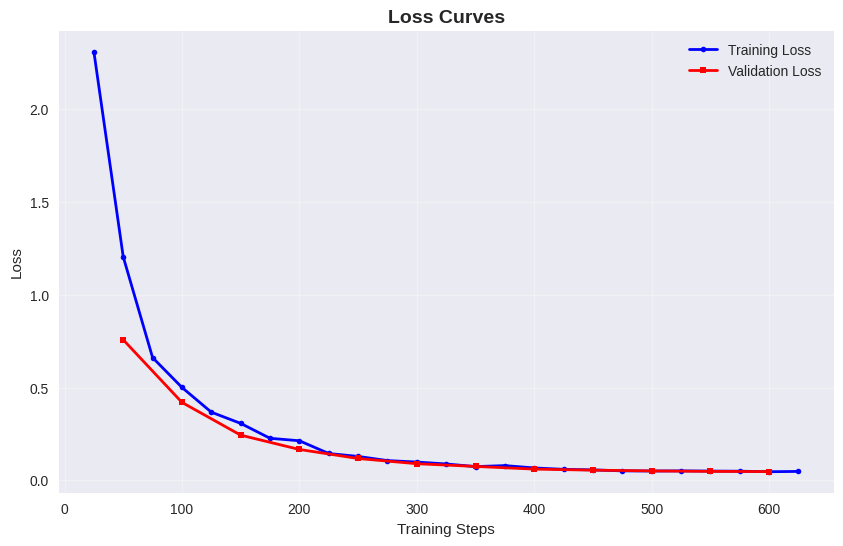

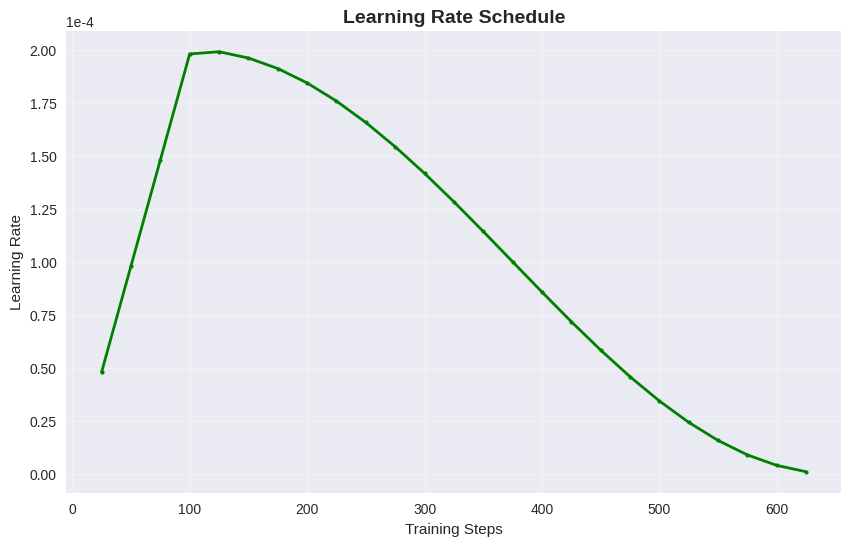

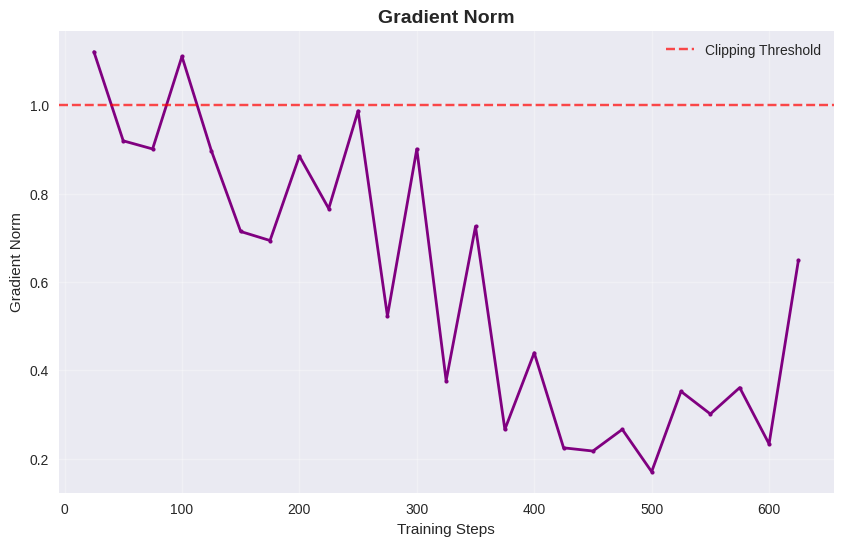

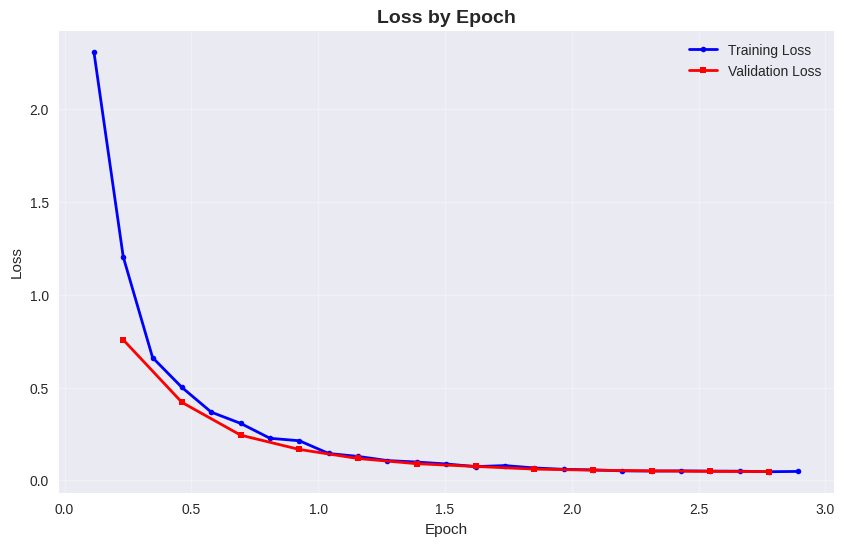

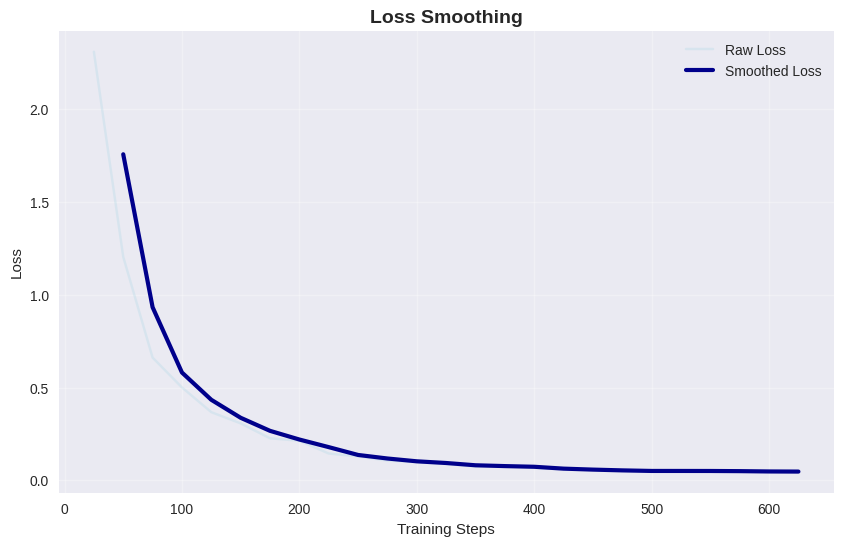

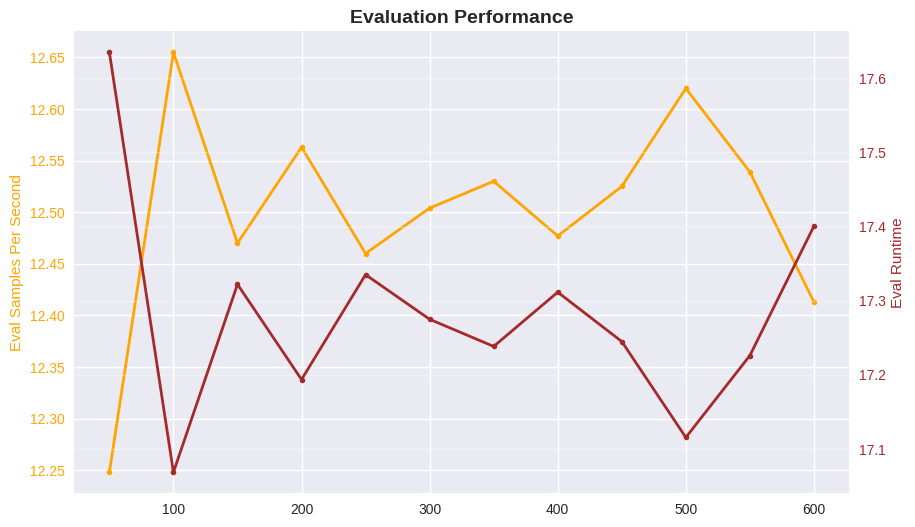


DETAILED TRAINING METRICS

TRAINING METRICS:
----------------------------------------
           Metric  Value
     Initial Loss 2.3110
       Final Loss 0.0474
        Best Loss 0.0458
   Loss Reduction 2.2636
Avg Gradient Norm 0.6000
Max Gradient Norm 1.1208

EVALUATION METRICS:
----------------------------------------
             Metric  Value
  Initial Eval Loss 0.7573
    Final Eval Loss 0.0465
     Best Eval Loss 0.0465
Eval Loss Reduction 0.7108
      Avg Eval Time 17.28s
    Avg Samples/Sec  12.50

TRAINING EFFICIENCY:
----------------------------------------
                 Metric    Value
            Total Steps      625
           Total Epochs     2.89
Loss Reduction per Step 0.003622
        Steps per Epoch    216.0

Training data saved to: training_logs.csv
Evaluation data saved to: evaluation_logs.csv


In [42]:
train_df, eval_df = analyze_your_training_logs(trainer)

In [43]:
output_dir = "/content/drive/MyDrive/nsc/model-finetuned/default"  # หรือเปลี่ยนชื่อเป็นเวอร์ชันของคุณ

# สมมติว่า `model` และ `tokenizer` คือออบเจกต์ที่ผ่านการฝึกมาเรียบร้อยแล้ว
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Saved finetuned model & tokenizer to {output_dir}")


Saved finetuned model & tokenizer to /content/drive/MyDrive/nsc/model-finetuned/default


In [44]:
model.save_pretrained_gguf("/content/drive/MyDrive/nsc/model-finetuned/q4km", tokenizer, quantization_method = "q4_k_m")

Unsloth: Will remove a cached repo with size 17.3M


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 4.23 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 16/16 [00:00<00:00, 22.62it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving /content/drive/MyDrive/nsc/model-finetuned/q4km/pytorch_model.bin...
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: CMAKE detected. Finalizing some steps for installation.
Unsloth: [1] Converting model at /content/drive/MyDrive/nsc/model-finetuned/q4km into f16 GGUF format.
The output location will be /content/drive/MyDrive/nsc/model-finetuned/q4km/unsloth.F16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: q4km
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Expo

In [45]:
%cd llama.cpp
!make LLAMA_CUBLAS=1  # ถ้าใช้ GPU, หรือใช้ !make เฉยๆ ถ้าใช้ CPU

/content/llama.cpp/llama.cpp
Makefile:2: *** The Makefile build is deprecated. Use the CMake build instead. For more details, see https://github.com/ggml-org/llama.cpp/blob/master/docs/build.md.  Stop.


In [46]:
!python3 convert.py \
  --outfile ../finetuned-llama2-13b.gguf \
  --in-dir ../finetuned_llama2-13b \
  --vocab-type sentencepiece \
  --model-type llama


python3: can't open file '/content/llama.cpp/llama.cpp/convert.py': [Errno 2] No such file or directory
